<a href="https://colab.research.google.com/github/raffeekk/curse-work-ML25/blob/main/notebooks/01_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовая работа по дисциплине "Машинное обучение"

### Автор: Горбуненко Дмитрий Денисович.
### Группа: КРНД23-ПМиИ-АД-о.
### Анализ и прогнозирование цен на недвижимость с использованием методов машинного обучения


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer



Загрузка тренировочного и тестового наборов данных

Parameters:

train_path : str
    Путь к файлу с тренировочными данными
test_path : str
    Путь к файлу с тестовыми данными

Returns:

tuple
    (train_df, test_df) - загруженные датафреймы



In [105]:
def load_data(train_path, test_path):

    test_path = "https://raw.githubusercontent.com/raffeekk/curse-work-ML25/refs/heads/main/data/test.csv"
    train_path = "https://raw.githubusercontent.com/raffeekk/curse-work-ML25/refs/heads/main/data/train.csv"

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

Анализ пропущенных значений в датафрейме

Parameters:

df : pandas.DataFrame
    Датафрейм для анализа

Returns:

pandas.DataFrame
    Датафрейм с информацией о пропущенных значениях

In [106]:
def analyze_missing_values(df):

    missing_values = df.isnull().sum()
    missing_percentages = (missing_values / len(df)) * 100

    missing_df = pd.DataFrame({
        'Количество пропущенных': missing_values,
        'Процент пропущенных': missing_percentages
    })

    return missing_df[missing_df['Количество пропущенных'] > 0].sort_values('Количество пропущенных', ascending=False)

Обработка пропущенных значений

Parameters:

df : pandas.DataFrame
    Датафрейм для обработки
strategy : str
    Стратегия заполнения пропущенных значений ('mean', 'median', 'most_frequent')

Returns:

pandas.DataFrame
    Обработанный датафрейм

In [107]:
def handle_missing_values(df, strategy='mean'):

    numeric_columns = df.select_dtypes(include=[np.number]).columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Обработка числовых признаков
    if len(numeric_columns) > 0:
        numeric_imputer = SimpleImputer(strategy=strategy)
        df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

    # Обработка категориальных признаков
    if len(categorical_columns) > 0:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

    return df

Кодирование категориальных признаков

Parameters:

df : pandas.DataFrame
    Датафрейм для кодирования

Returns:

pandas.DataFrame
    Кодированный датафрейм

In [108]:
def encode_categorical_features(df):

    categorical_columns = df.select_dtypes(include=['object']).columns
    label_encoders = {}

    for column in categorical_columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column].astype(str))

    return df, label_encoders



Подготовка данных для обучения

Parameters:

train_df : pandas.DataFrame
    Тренировочный датафрейм
test_df : pandas.DataFrame
    Тестовый датафрейм

Returns:

tuple
    (X_train, y_train, X_test) - подготовленные данные



In [109]:
def prepare_data(train_df, test_df):

    # Сохраняем целевую переменную
    y_train = train_df['SalePrice']

    # Удаляем целевую переменную из тренировочных данных
    train_df = train_df.drop('SalePrice', axis=1)

    # Обработка пропущенных значений
    train_df = handle_missing_values(train_df)
    test_df = handle_missing_values(test_df)

    # Кодирование категориальных признаков
    train_df, label_encoders = encode_categorical_features(train_df)
    test_df, _ = encode_categorical_features(test_df)

    return train_df, y_train, test_df

Настройка стиля графиков

In [110]:
plt.style.use('seaborn-v0_8')  # Исправляем устаревший стиль
sns.set_style('whitegrid')

Функции визуализации (перемещаем в начало)

In [111]:
def save_plot(fig, filename):
    plt.tight_layout()
    plt.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')
    plt.close()

In [112]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', lw=2)
    plt.xlabel('Реальные значения (log scale)')
    plt.ylabel('Предсказанные значения (log scale)')
    plt.title(f'Сравнение предсказаний с реальными значениями\n{model_name}')
    save_plot(plt.gcf(), f'predictions_{model_name.lower().replace(" ", "_")}')

In [113]:
def plot_feature_importance(model, feature_names, model_name):
    if model_name == 'Random Forest':
        importance = model.feature_importances_
    else:  # XGBoost
        importance = model.feature_importances_

    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=feat_imp.head(20), x='importance', y='feature')
    plt.title(f'Топ-20 важных признаков ({model_name})')
    plt.xlabel('Важность признака')
    save_plot(plt.gcf(), f'feature_importance_{model_name.lower().replace(" ", "_")}')


Загрузка данных

In [114]:
df = pd.read_csv("https://raw.githubusercontent.com/raffeekk/curse-work-ML25/refs/heads/main/data/train.csv")
print('Размер датасета:', df.shape)
print('\nИнформация о датасете:')
df.info()

Размер датасета: (1460, 81)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  

Определяем числовые признаки

In [115]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns

Визуализация данных

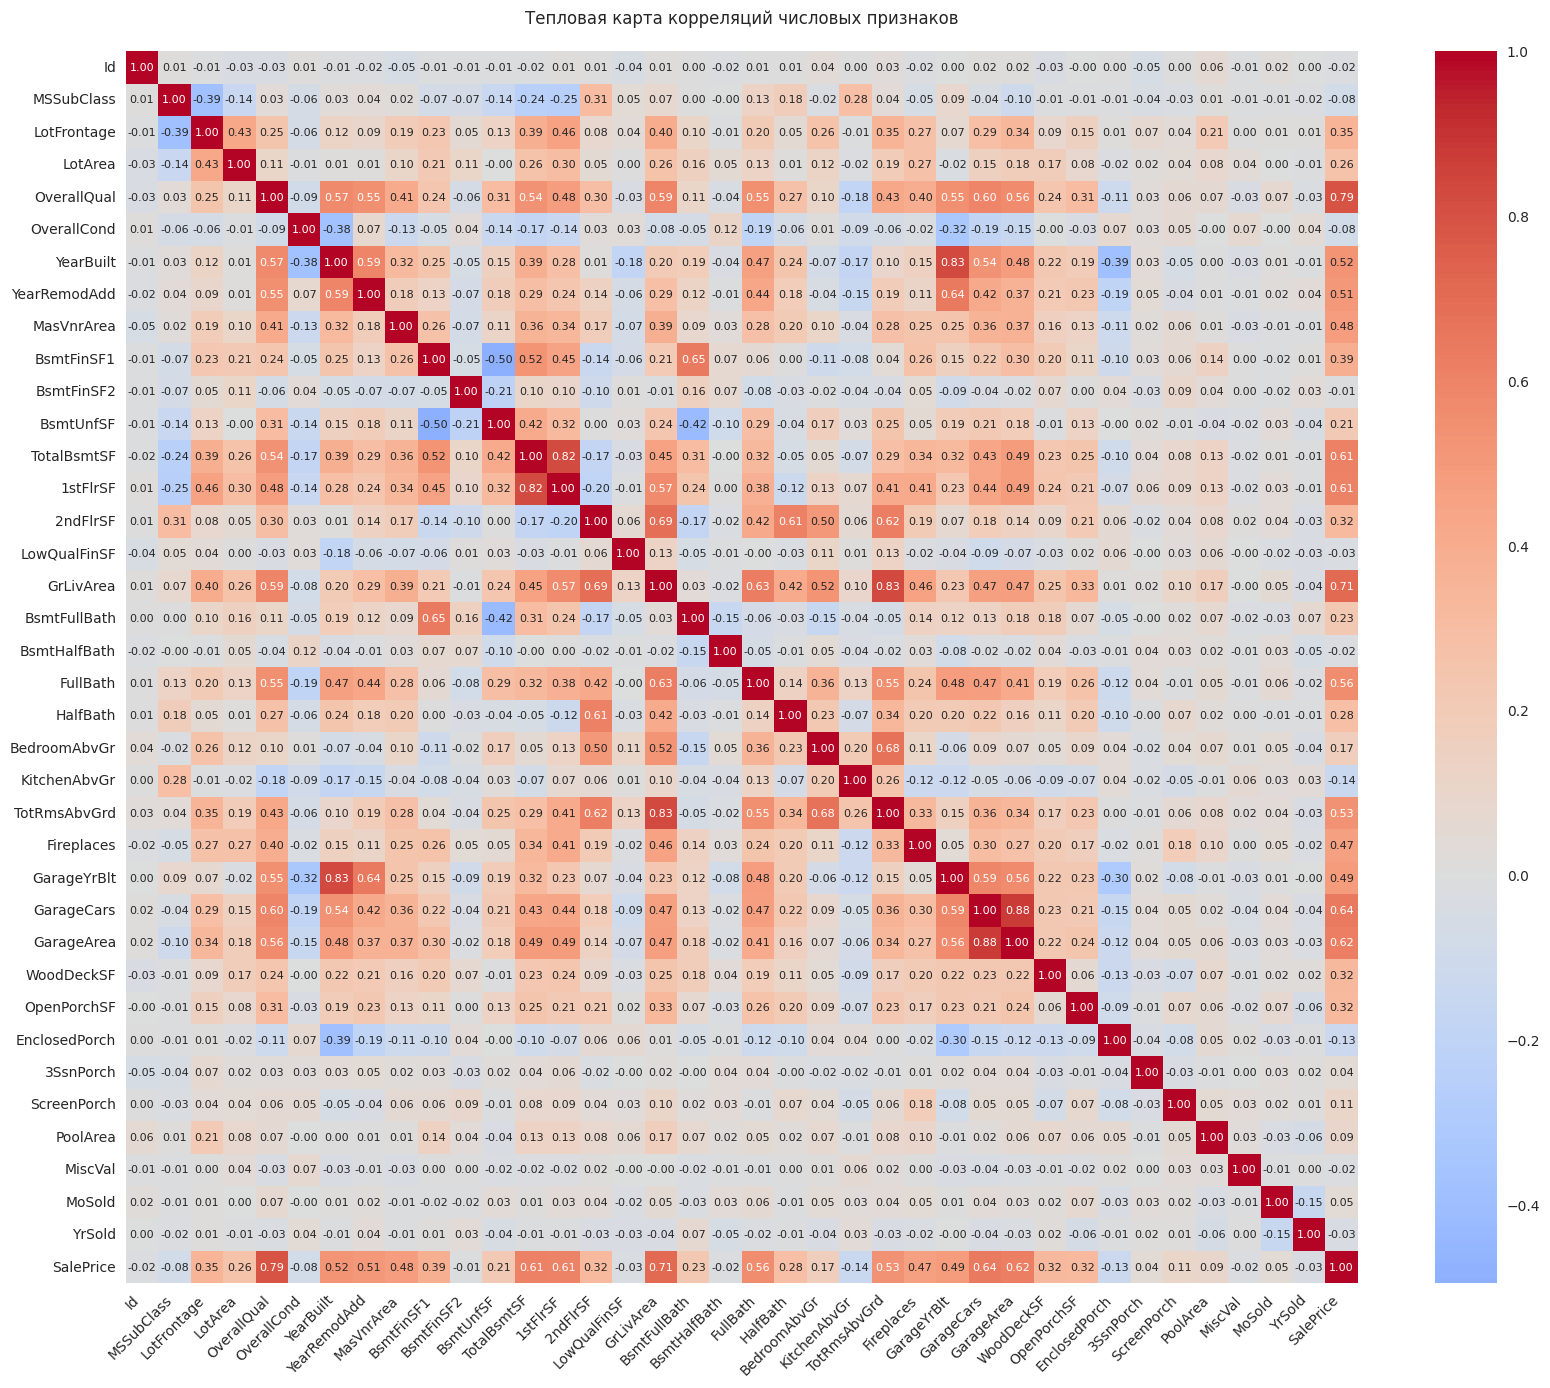

In [116]:
plt.figure(figsize=(20, 16))  # Увеличиваем размер графика
sns.heatmap(df[numeric_features].corr(),
            annot=True,  # Показываем значения
            cmap='coolwarm',
            center=0,
            fmt='.2f',  # Округляем значения до 2 знаков
            annot_kws={'size': 8},  # Уменьшаем размер шрифта значений
            square=True)  # Делаем ячейки квадратными
plt.xticks(rotation=45, ha='right')  # Поворачиваем подписи осей
plt.yticks(rotation=0)
plt.title('Тепловая карта корреляций числовых признаков', pad=20)  # Добавляем отступ для заголовка
plt.show()
# save_plot(plt.gcf(), 'correlation_heatmap')

2.2 Анализ распределения важных числовых признаков

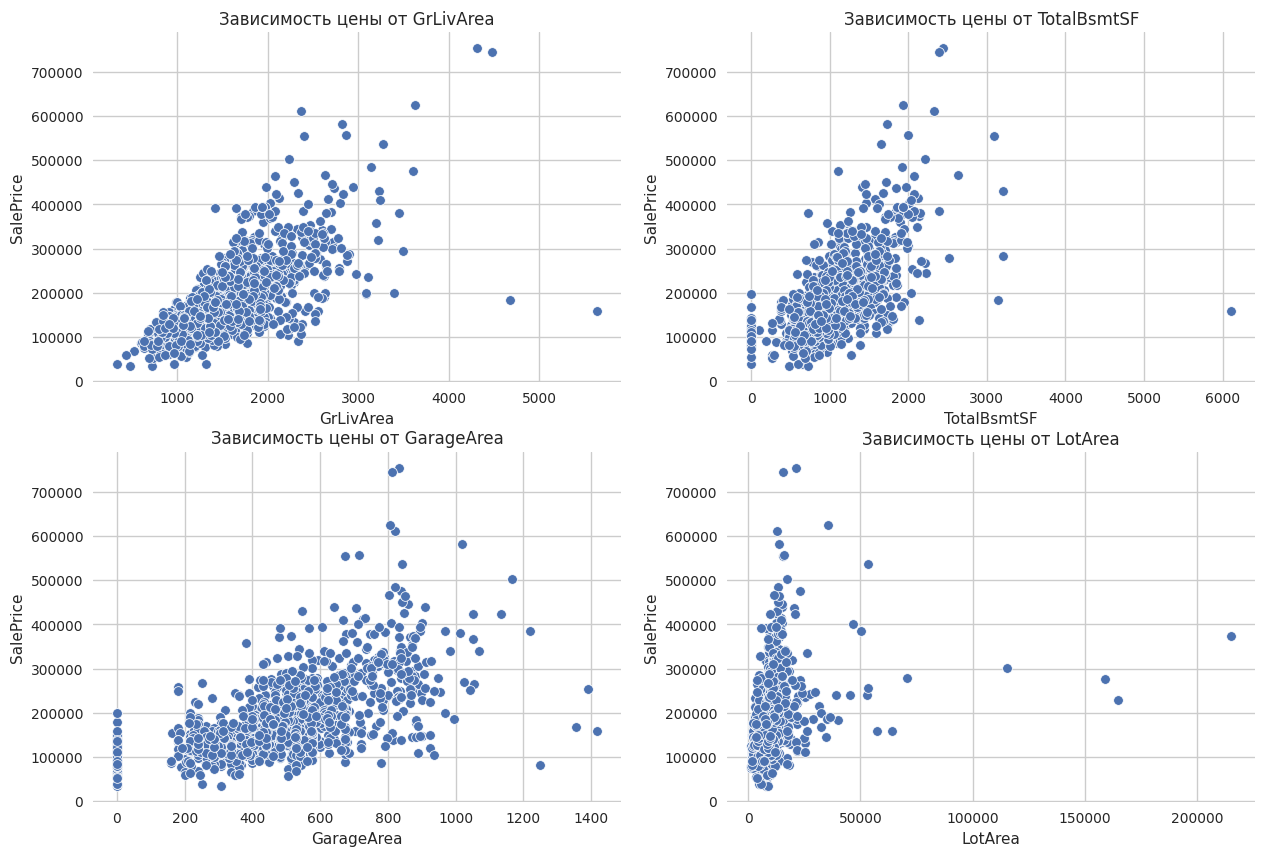

In [117]:
important_features = ['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'LotArea']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for idx, feature in enumerate(important_features):
    row = idx // 2
    col = idx % 2
    sns.scatterplot(data=df, x=feature, y='SalePrice', ax=axes[row, col])
    axes[row, col].set_title(f'Зависимость цены от {feature}')
# save_plot(plt.gcf(), 'important_features_scatter')
plt.show()

2.3 Boxplot для категориальных признаков

<ipython-input-118-3c00065e559f>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
<ipython-input-118-3c00065e559f>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
<ipython-input-118-3c00065e559f>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
<ipython-input-118-3c00065e559f>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)


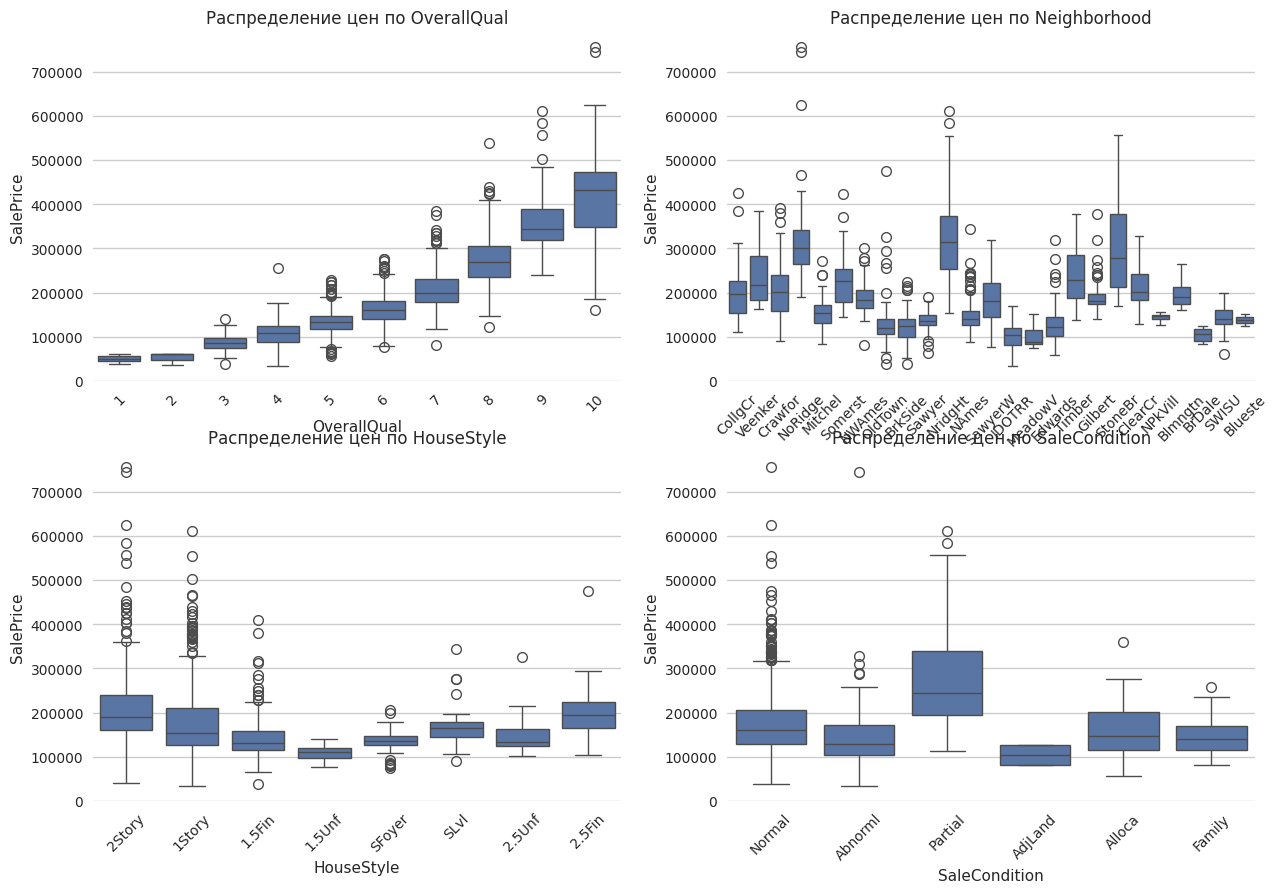

In [118]:
categorical_features = ['OverallQual', 'Neighborhood', 'HouseStyle', 'SaleCondition']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for idx, feature in enumerate(categorical_features):
    row = idx // 2
    col = idx % 2
    sns.boxplot(data=df, x=feature, y='SalePrice', ax=axes[row, col])
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
    axes[row, col].set_title(f'Распределение цен по {feature}')
# save_plot(plt.gcf(), 'categorical_features_boxplot')
plt.show()

Анализ пропущенных значений

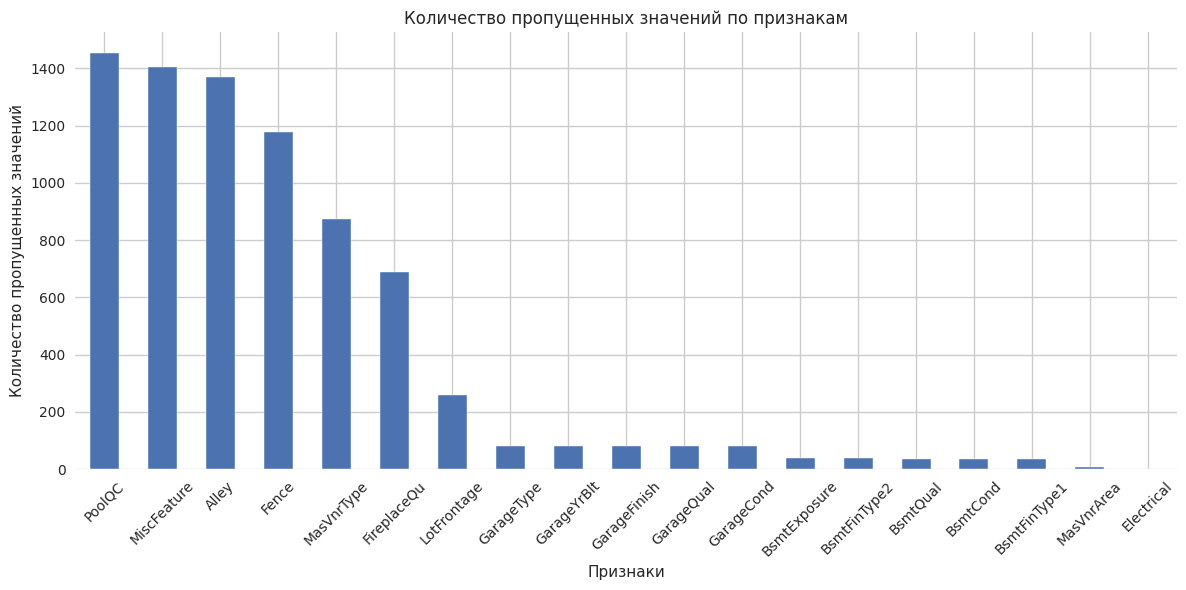

In [119]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar')
plt.title('Количество пропущенных значений по признакам')
plt.xlabel('Признаки')
plt.ylabel('Количество пропущенных значений')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('figures/missing_values.png')
plt.show()
plt.close()

Анализ целевой переменной

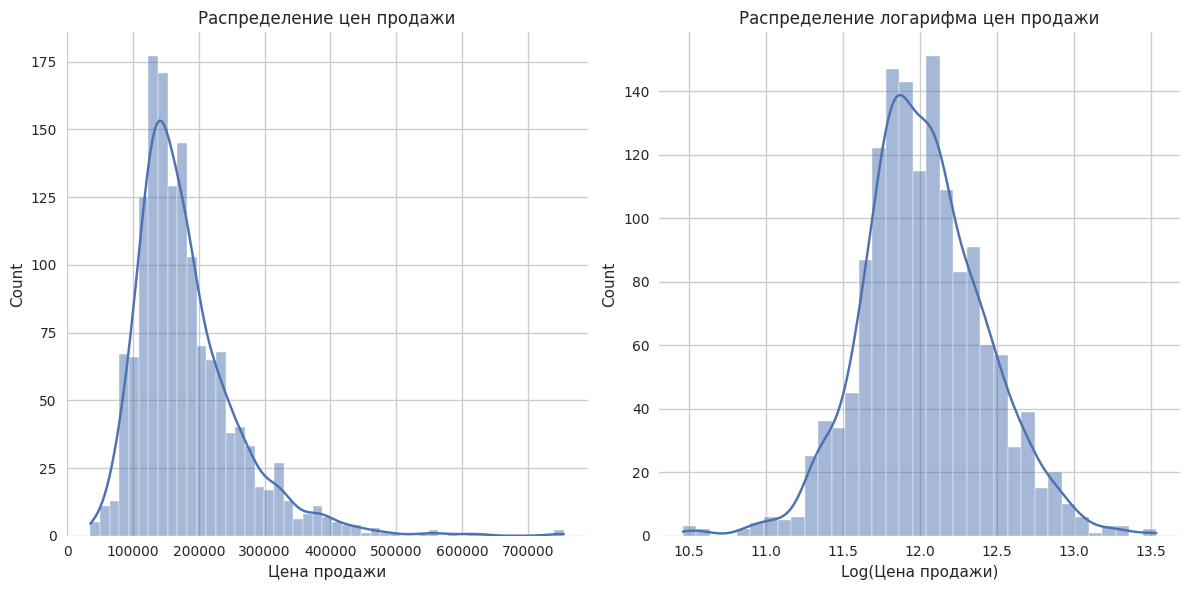


Основные статистики цен продажи:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [120]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['SalePrice'], kde=True)
plt.title('Распределение цен продажи')
plt.xlabel('Цена продажи')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['SalePrice']), kde=True)
plt.title('Распределение логарифма цен продажи')
plt.xlabel('Log(Цена продажи)')

plt.tight_layout()
# plt.savefig('figures/price_distribution.png')
plt.show()
plt.close()

print('\nОсновные статистики цен продажи:')
print(df['SalePrice'].describe())

5. Корреляционный анализ

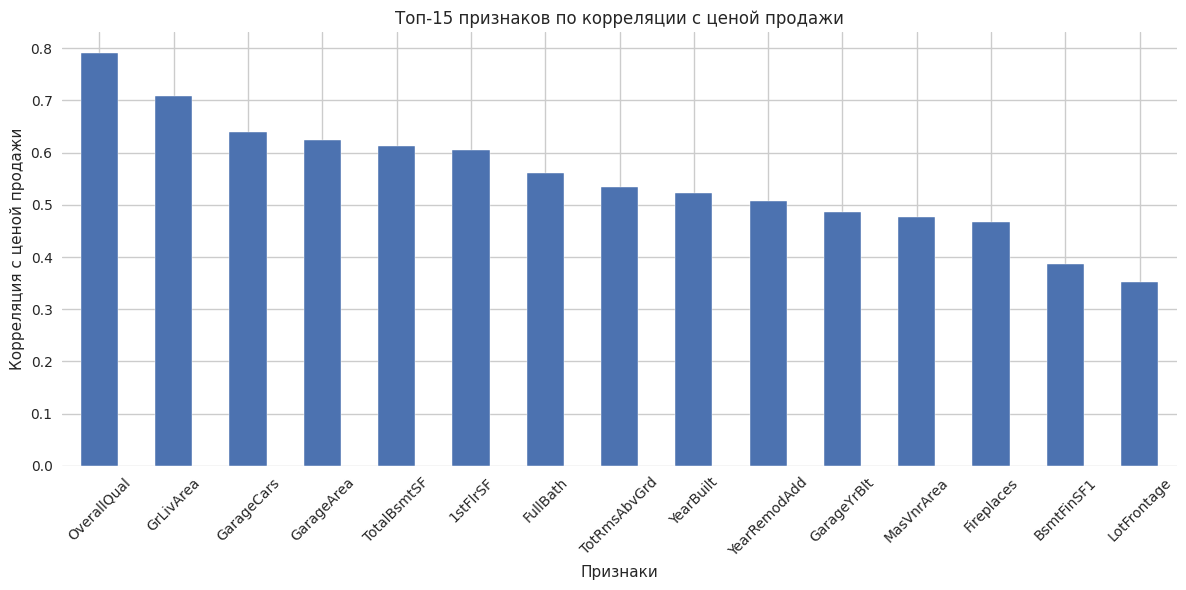

In [121]:
correlations = df[numeric_features].corr()['SalePrice'].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
correlations[1:16].plot(kind='bar')
plt.title('Топ-15 признаков по корреляции с ценой продажи')
plt.xlabel('Признаки')
plt.ylabel('Корреляция с ценой продажи')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('figures/correlations.png')
plt.show()
plt.close()

Подготовка данных

In [122]:
def prepare_data(df):
    df_prep = df.copy()

    numeric_features = df_prep.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = df_prep.select_dtypes(include=['object']).columns

    for feature in numeric_features:
        df_prep[feature].fillna(df_prep[feature].median(), inplace=True)

    for feature in categorical_features:
        df_prep[feature].fillna(df_prep[feature].mode()[0], inplace=True)

    df_prep = pd.get_dummies(df_prep, columns=categorical_features)

    return df_prep

In [123]:
df_prepared = prepare_data(df)

X = df_prepared.drop(['SalePrice', 'Id'], axis=1)
y = np.log1p(df_prepared['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('\nРазмеры обучающей выборки:', X_train_scaled.shape)
print('Размеры тестовой выборки:', X_test_scaled.shape)

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Сначала вычислим метрики для логарифмированных значений
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_log = r2_score(y_test, y_pred)

    # Затем аккуратно выполним обратное преобразование
    try:
        y_true_exp = np.expm1(y_test)
        y_pred_exp = np.expm1(y_pred)

        # Обрезаем слишком большие значения
        max_price = 1000000  # Максимальная цена в $1M
        y_pred_exp = np.clip(y_pred_exp, 0, max_price)

        rmse = np.sqrt(mean_squared_error(y_true_exp, y_pred_exp))
        r2 = r2_score(y_true_exp, y_pred_exp)
    except:
        print(f"Предупреждение: Не удалось вычислить метрики в исходном масштабе для {model_name}")
        rmse = rmse_log
        r2 = r2_log

    print(f'\nРезультаты для модели {model_name}:')
    print(f'RMSE (log scale): {rmse_log:.4f}')
    print(f'R2 Score (log scale): {r2_log:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2 Score: {r2:.4f}')

    # Визуализация в логарифмическом масштабе
    plot_predictions(y_test, y_pred, model_name)

    return rmse, r2


Размеры обучающей выборки: (1168, 287)
Размеры тестовой выборки: (292, 287)


<ipython-input-122-b45810afa4d7>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_prep[feature].fillna(df_prep[feature].median(), inplace=True)
<ipython-input-122-b45810afa4d7>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

Обучение моделей

In [124]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}


Результаты для модели Linear Regression:
RMSE (log scale): 0.1244
R2 Score (log scale): 0.9170
RMSE: 22131.6587
R2 Score: 0.9361


FileNotFoundError: [Errno 2] No such file or directory: 'figures/predictions_linear_regression.png'

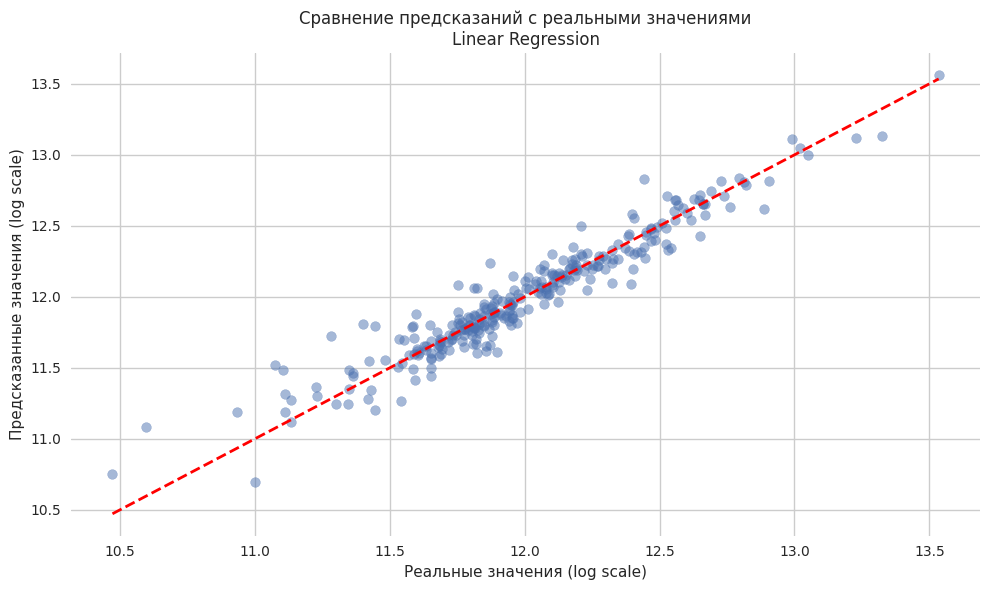

In [125]:
results = {}
for name, model in models.items():
    rmse, r2 = train_and_evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results[name] = {'RMSE': rmse, 'R2': r2}

    if name in ['Random Forest', 'XGBoost']:
        plot_feature_importance(model, X.columns, name)

Визуализация результатов моделей

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
rmse_values = [results[model]['RMSE'] for model in results]
plt.bar(results.keys(), rmse_values)
plt.title('Сравнение моделей по RMSE')
plt.xticks(rotation=45)
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
r2_values = [results[model]['R2'] for model in results]
plt.bar(results.keys(), r2_values)
plt.title('Сравнение моделей по R2')
plt.xticks(rotation=45)
plt.ylabel('R2 Score')
plt.show()
# save_plot(plt.gcf(), 'model_comparison')